<a href="https://colab.research.google.com/github/ViktorKitanov/CAS_ADS_2023_24/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Packages

In [ ]:
#Google Big Query related packages
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time


#Authenticate Google Big Query Access

In [ ]:
auth.authenticate_user()
print('Authenticated')

Authenticated


##Connect to Big Query and Get Data

In [ ]:

project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset`;"
Query_Results = bigquery_client.query(Query)
df = Query_Results.to_dataframe()
df

#Copy Dataset
Data_Adf = df.copy()

#Account for Null Values
Data_Adf.replace('<NA>', np.nan, inplace=True)

In [ ]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)



#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()


#Data Analysis

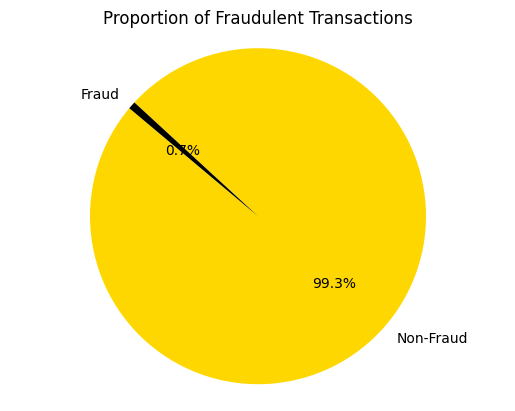

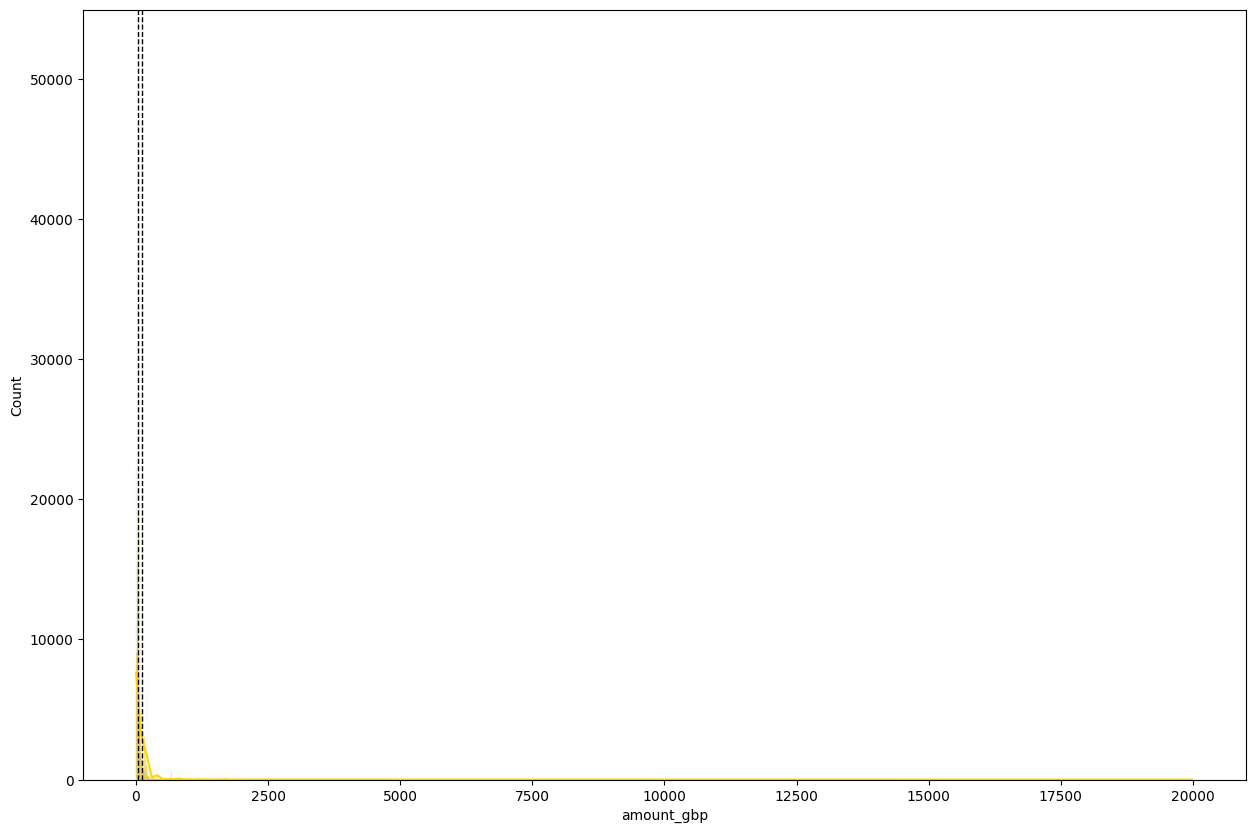

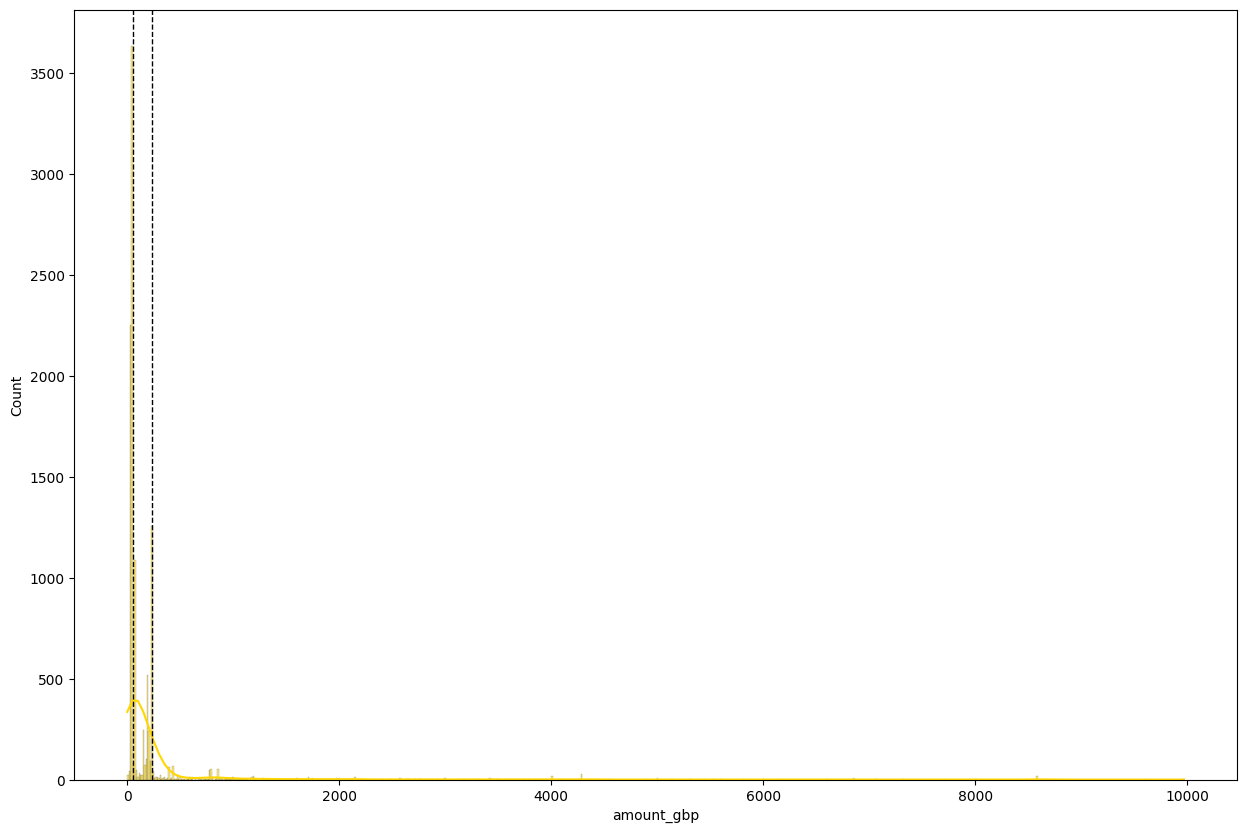

In [ ]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles

In [ ]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','mean','median']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','std']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','mean_nb_trx_per_day']

#Merge Datasets to one
cust_profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
cust_profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
cust_profiles

,client_id,mean,median,std,mean_nb_trx_per_day
0,1058555,53.65,53.65,0.0,1.0
1,1058557,53.65,53.65,0.0,1.0
2,1058558,157.75,157.75,0.0,1.0
3,1058561,37.64,37.64,0.0,1.0
4,1058565,37.64,37.64,0.0,1.0
...,...,...,...,...,...
930230,4643209,74.33,74.33,0.0,1.0
930231,4643210,63.65,63.65,0.0,1.0
930232,4643212,11.98,11.98,0.0,1.0
930233,4643215,71.79,71.79,0.0,1.0
